<a href="https://colab.research.google.com/github/Stefan-JunqingShi0718/edge-computer-vision/blob/master/Assignment2_Cece(Siyuan_Zhang)_SVHN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset
download SVHN dataset Format2. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows.

In [ ]:
# 装在网盘

In [ ]:
%cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
! pwd

/content/drive/My Drive


In [ ]:
! ls

'Assignment 2-Cece(Siyuan Zhang)-total.mov'
'Colab Notebooks'
'How to get started with Drive.pdf'
 train_32x32.mat


In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat

--2020-06-17 13:25:35--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  54.0MB/s    in 4.0s    

2020-06-17 13:25:39 (43.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]



## data analysis

In [ ]:
# TensorFlow
%tensorflow_version 2.x
import tensorflow as tf

# kears model building blocks
from tensorflow.keras.layers import Input, Dense,\
 Conv2D, Conv2DTranspose, Reshape, BatchNormalization,\
 LeakyReLU, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Default libraries
import time
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import scipy.io as io
data = io.loadmat("train_32x32.mat")

In [ ]:
print(data.keys())
print(data['X'].shape)
print(data['y'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(32, 32, 3, 73257)
(73257, 1)


In [ ]:
X_train = data['X'].transpose(3,0,1,2) / 255
print(X_train.shape)

(73257, 32, 32, 3)


In [ ]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)\
.shuffle(BUFFER_SIZE)\
.batch(BATCH_SIZE)

## visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


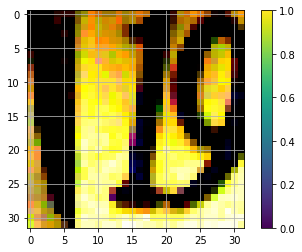

In [ ]:
# 看一下数据究竟长什么样子，看一张图片
# 貌似归一化后的图片对比度会变的更明显？

# figure1 = X_train[0]
figure1 = (figure1 - figure1.mean()) / figure1.std()
plt.figure()
plt.imshow(figure1)
plt.colorbar()
plt.grid(True)
plt.show()

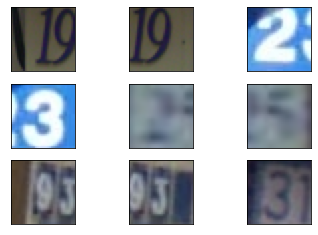

In [ ]:
def plot_images(img, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])

# Plot some training set images
plot_images(X_train, 3, 3)

# Creat the Models

## The discriminator

In [ ]:
INPUT_DIM = [32, 32, 3]

def make_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=INPUT_DIM), 
        LeakyReLU(), 
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'), 
        LeakyReLU(), 
        Dropout(0.3),

        Flatten(), 
        Dense(1)
        ])
    
    return model

In [ ]:
# 测试一下discriminator能不能用
discriminator = make_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.09712363]], shape=(1, 1), dtype=float32)


## The generator

In [ ]:
z_dim = 128

def make_generator():
    model = Sequential([
        Dense(8*8*256, input_shape=([z_dim,])),
        BatchNormalization(),
        LeakyReLU(),
        Reshape([8, 8, 256]),
        
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='sigmoid')
        ])
    
    return model

(1, 128)
(1, 32, 32, 3)


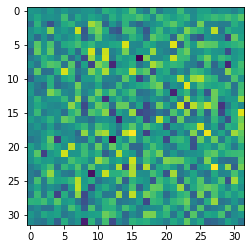

In [ ]:
# 测试一下 generator 能不能用
generator = make_generator()

noise = tf.random.normal([1, 128])

generated_image = generator(noise, training=False)

print(noise.shape)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])  

# Define the loss and optimizers

## the discriminator loss

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True)

In [ ]:
# 希望真图片就是真的
# 希望能鉴别出假图片
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## the generator loss

In [ ]:
# 希望生成器生成的图片越真越好，
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
discriminator_optimizer = Adam(1e-4)
generator_optimizer = Adam(1e-4)

# Define the training Loop

In [ ]:
EPOCHS = 500
noise_dim = 128
num_examples_to_generate = 25

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    print("start")
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, 
                                                    time.time()-start))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=True)

    fig = plt.figure(figsize=(6,6))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

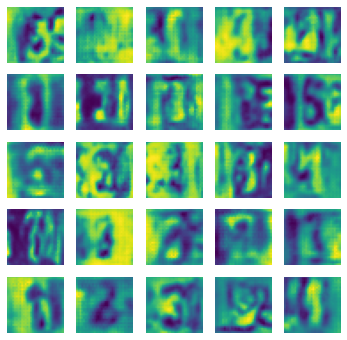

Time for epoch 500 is 17.96954584121704 sec


In [ ]:
train(train_dataset, EPOCHS)